In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import sys; sys.path.append('..')
from sgr_tools.ScenarioGeneration.Parametric.Forecast.Models import MARX
from sgr_tools.ScenarioGeneration.Parametric.Forecast.Tools import Splines, PeriodicForecast
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
n = 8760
idx = pd.date_range(start="2020-01-01", periods=n, freq="H")

heat_load = pd.Series(
    sm.tsa.ArmaProcess(
        np.r_[1, -np.random.rand(1)],
        np.r_[1, -np.random.rand(1)],
    ).generate_sample(nsample=n),
    index=idx,
)
solar = pd.Series(
    sm.tsa.ArmaProcess(
        np.r_[1, -np.random.rand(1)],
        np.r_[1, -np.random.rand(1)],
    ).generate_sample(nsample=n),
    index=idx,
)


bs_df = 4
exog = Splines(seasonality=24, degrees_freedom=bs_df).get_fit(idx=heat_load.index)
df = pd.DataFrame({'heat_load': heat_load, 'solar': solar})

/var/folders/_0/pycjxcpn11j1k41mjdskw2rc0000gn/T/ipykernel_72814/1317458891.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(start="2020-01-01", periods=n, freq="H")


In [3]:
marx = MARX()
periodic_forecast = PeriodicForecast(model=marx)
periodic_forecast.simulate_periodic_scenario_sets(
    observations=pd.DataFrame({'heat_load': df['heat_load']}),
    exog=exog,
    n_train = 168 * 8,  # 8 weeks of training data per model fit
    n_scen=10, # 10 scenarios
    t_start=idx[168 * 10], # start at idx[0] + 10 weeks
    t_end=idx[168 * 13],  # end at idx[0] + 13 weeks
    scenario_len=48, # 48 hours per scenario
    forecast_freq=24, # move rolling horizon by 24h after each forecaste
    lags=[1]
)


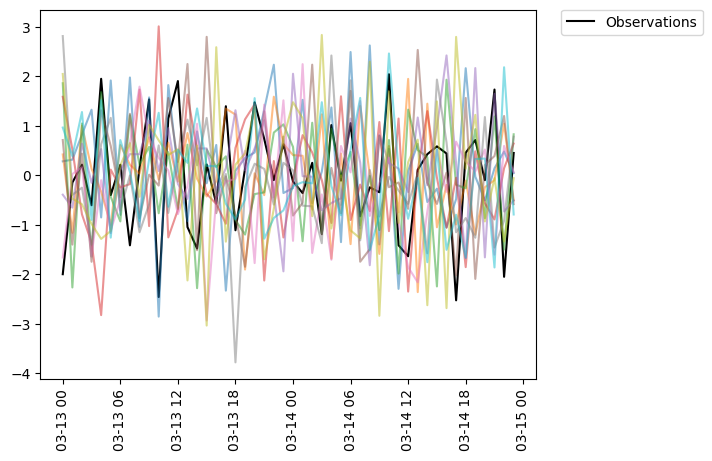

In [4]:
obs = periodic_forecast.get_observations(2)['heat_load']
fig, ax = plt.subplots()
ax.plot(obs, label='Observations', color='black')
ax.plot(obs.index, periodic_forecast.get_scenarios(2).data['heat_load'], alpha=0.5)
plt.xticks(rotation=90)



plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)